<a href="https://colab.research.google.com/github/kashyab12/RAN-Slicing-Simulation/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib
!pip install import_ipynb

Executing: /tmp/apt-key-gpghome.rJmMzL2DFD/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://downloa

In [18]:
!git clone https://github.com/kashyab12/RAN-Slicing-Simulation.git

fatal: destination path 'RAN-Slicing-Simulation' already exists and is not an empty directory.


In [22]:
import import_ipynb
import RanSlice as rn
from graph_tool.all import *

In [24]:
rn.createRANSlices()
rn.setRANSliceProperties()
rn.createVNFFunctions()
rn.setVNFFunctionProperties()
rn.createVNFConnections()

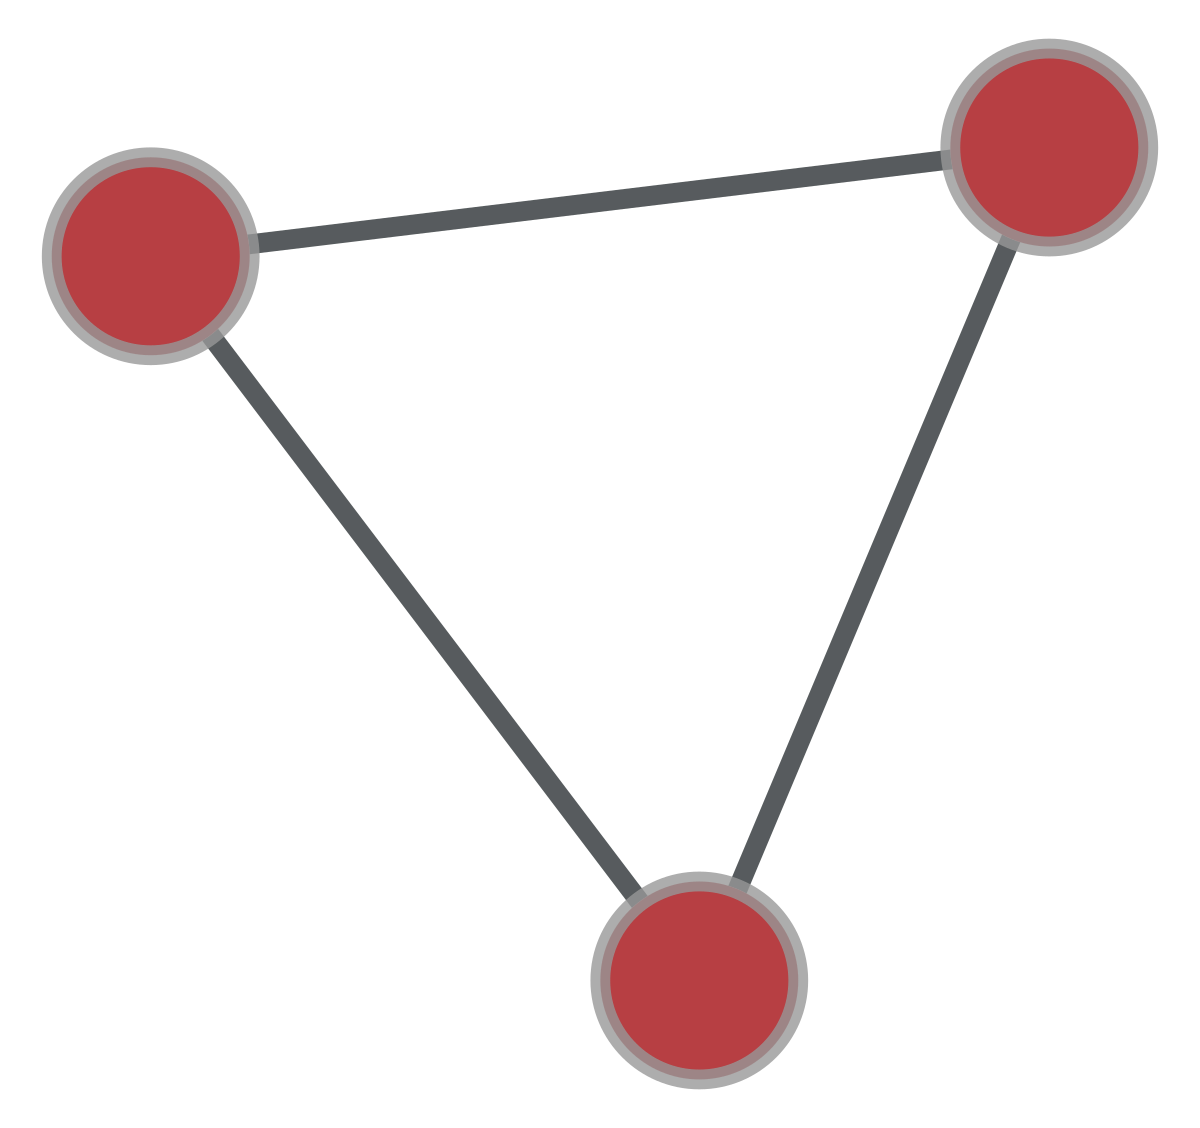

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f966323b4e0, at 0x7f965b7fbd30>